In [1]:
import matplotlib.pyplot as plt
import pandas
import structlog
from astropy import coordinates
from astropy import units as u

from app.lib.storage import postgres


In [2]:
from experiments import entities, plots

storage_config = postgres.PgStorageConfig(
    endpoint="dm2.sao.ru", port=5432, dbname="hyperleda", user="hyperleda", password=""
)

In [3]:
import ast

df = pandas.read_csv("experiments/results/bayes_10arcsec.csv")

# df = df[df["status"] == "collision"]
# print(df.head())
total_objects = len(df)
new_count = len(df[df["status"] == "new"])
existing_count = len(df[df["status"] == "existing"])
collision_count = len(df[df["status"] == "collision"])
print("\nCross-Identification Summary:")
print(f"Total objects: {total_objects}")
print(f"New objects: {new_count} ({new_count / total_objects * 100:.1f}%)")
print(f"Existing objects: {existing_count} ({existing_count / total_objects * 100:.1f}%)")
print(f"Collisions: {collision_count} ({collision_count / total_objects * 100:.1f}%)")

df = df[df["status"] == "collision"]

rows = df.to_dict(orient="records")
for i in range(len(rows)):
    rows[i]["pgc_numbers"] = ast.literal_eval(rows[i]["pgc_numbers"])


Cross-Identification Summary:
Total objects: 500
New objects: 470 (94.0%)
Existing objects: 28 (5.6%)
Collisions: 2 (0.4%)


2025-07-30 22:10:30 [debug    ] connecting to Postgres         endpoint=dm2.sao.ru port=5432
2025-07-30 22:10:31 [debug    ] SQL query                      args=[[4676863, 1037710, 4531097, 4675996, 4676895], [4676863, 1037710, 4531097, 4675996, 4676895], 5, 0] query='             WITH              t0 AS (                 SELECT pgc, ra AS "icrs|ra", e_ra AS "icrs|e_ra", dec AS "icrs|dec", e_dec AS "icrs|e_dec"                 FROM layer2.icrs                 WHERE pgc = ANY(%s)             ),              t1 AS (                 SELECT pgc, design AS "designation|design"                 FROM layer2.designation                 WHERE pgc = ANY(%s)             )             SELECT COALESCE(t0.pgc, t1.pgc) AS pgc,                    t0."icrs|ra", t0."icrs|e_ra", t0."icrs|dec", t0."icrs|e_dec", t1."designation|design"             FROM t0 FULL OUTER JOIN t1 USING (pgc)             ORDER BY pgc             LIMIT %s OFFSET %s         '
2025-07-30 22:10:31 [debug    ] SQL result               

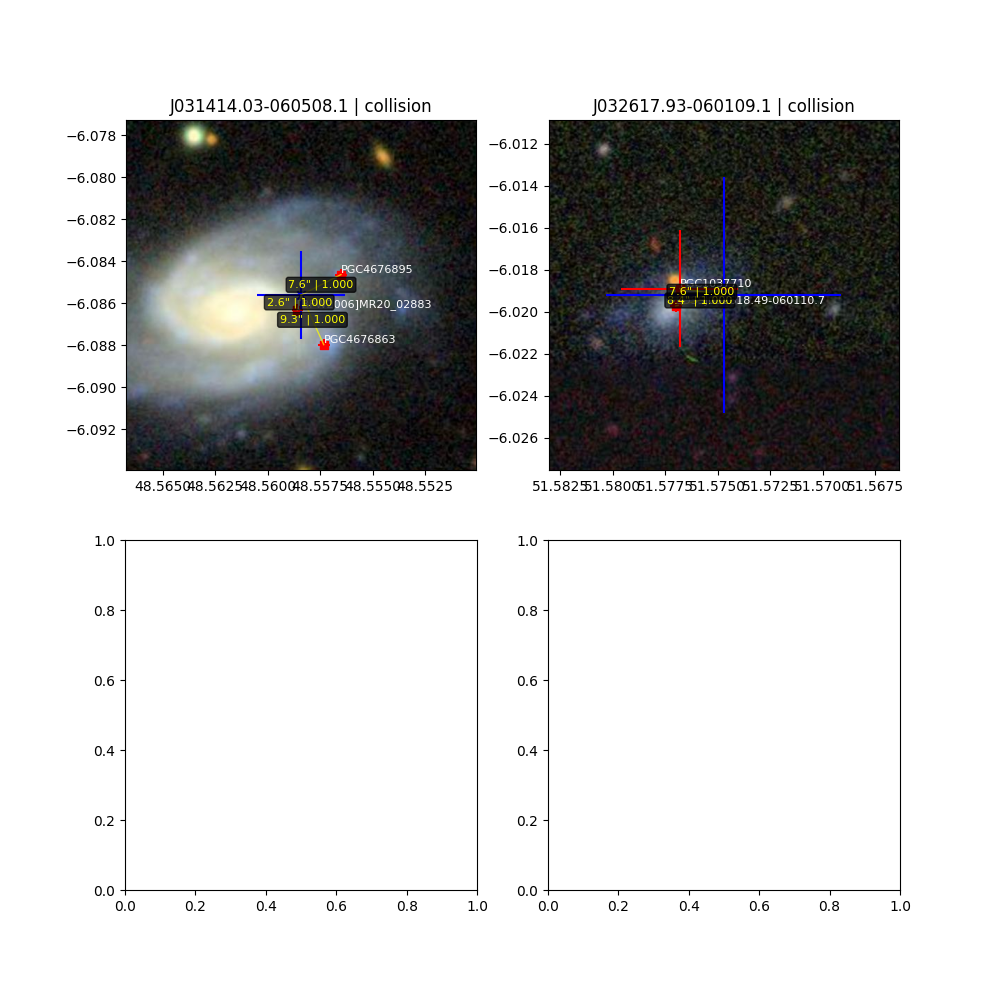

In [7]:
%matplotlib widget

storage = postgres.PgStorage(storage_config, structlog.get_logger())
storage.connect()

offset = 0
grid_rows = 2
grid_cols = 2
num_objects = grid_rows * grid_cols
selected_objs = [entities.CrossIDInfo(**row) for row in rows[offset:num_objects+offset]]

fig, axes_arr = plt.subplots(grid_rows, grid_cols, figsize=(5 * grid_cols, 5 * grid_rows))

fov = 1 / 60
hips_map = 'CDS/P/DESI-Legacy-Surveys/DR10/color'

axes_flat = axes_arr.flatten()

try:
    all_pgc_numbers = set()
    obj_to_pgcs = []
    for obj in selected_objs:
        pgc_numbers = obj.pgc_numbers.keys()
        obj_to_pgcs.append(pgc_numbers)
        all_pgc_numbers.update(pgc_numbers)

    all_pgc_numbers = list(all_pgc_numbers)
    all_pgc_data = entities.get_pgc_objects_info(all_pgc_numbers, storage)
except Exception as e:
    raise e
finally:
    storage.disconnect()

pgc_to_obj = {obj.pgc: obj for obj in all_pgc_data}

for obj, ax, pgc_numbers in zip(selected_objs, axes_flat, obj_to_pgcs, strict=False):
   collision_data = [pgc_to_obj[pgc] for pgc in pgc_numbers if pgc in pgc_to_obj]
   coords = coordinates.SkyCoord(ra=obj.ra * u.deg, dec=obj.dec * u.deg)

   print(coords)
   print(collision_data)
   plots.get_hips_map(obj, fov, hips_map, collision_data, ax)

plt.show()